### Exercise 3.2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
N=150
p=3
sigma = 5.4

xmin = -2.
xmax = 3.

In [3]:
def create_data_matrix(x):
    """x: list or numpy array"""
    x = np.array(x)
    X = np.column_stack([x**i for i in range(p+1)])
    return X

def create_data_vector(x):
    """x: float"""
    x = np.array([x**i for i in range(p+1)])
    return x

In [4]:
beta = np.random.randn(p+1)*2
beta = np.array([3., 4., 1., 2.])
print(beta)

[3. 4. 1. 2.]


In [5]:
np.random.seed(0)
x_train = np.random.rand(N)*(xmax-xmin)+xmin
X_train = create_data_matrix(x_train)
y_train = X_train.dot(beta) + np.random.randn(N)*sigma

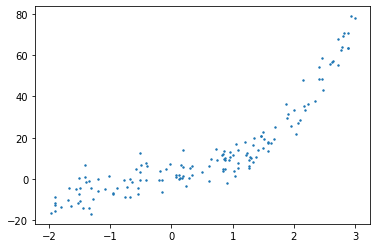

In [7]:
plt.scatter(x_train, y_train, s=2.);

In [8]:
XTXinv = np.linalg.inv(X_train.T.dot(X_train))

In [9]:
XTXinv.shape

(4, 4)

In [10]:
beta_hat = XTXinv.dot(X_train.T.dot(y_train))
print(beta_hat)

[1.93800172 3.856523   1.42765063 1.90064771]


In [11]:
x_dense = np.linspace(xmin, xmax, 100)
X_dense = create_data_matrix(x_dense)
y_dense = X_dense.dot(beta_hat)
y_dense_true = X_dense.dot(beta)

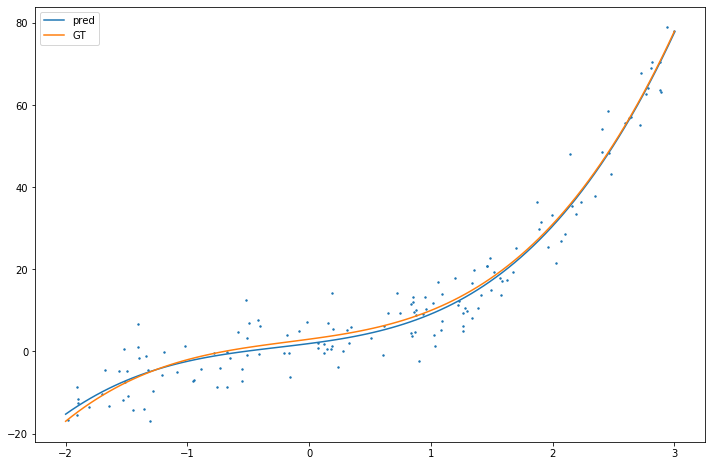

In [15]:
plt.figure(figsize=(12,8))
plt.plot(x_dense, y_dense, label='pred')
plt.plot(x_dense, y_dense_true, label='GT')
plt.scatter(x_train, y_train, s=2.)
plt.legend();

In [16]:
y_hat = X_train.dot(beta_hat)

In [17]:
RSS = np.linalg.norm(y_train-y_hat)**2
print(f"RSS: {RSS}")

RSS: 3652.4682788231867


In [18]:
sigma_hat = np.sqrt(RSS/(N-p-1))
print(f"sigma_hat: {sigma_hat}")

sigma_hat: 5.0016903162167985


### 95% CI at each point

In [19]:
v = np.diagonal(XTXinv)

In [20]:
z = norm.interval(0.95)[1]
beta_min = beta_hat - sigma_hat * np.sqrt(v) * z
beta_max = beta_hat + sigma_hat * np.sqrt(v) * z

In [21]:
print("intervals for beta:")
for i in range(len(beta_hat)):
    print(f"{beta_min[i]:.3f} ... {beta_max[i]:.3f}")

intervals for beta:
0.588 ... 3.288
2.643 ... 5.070
0.718 ... 2.137
1.557 ... 2.244


In [22]:
def get_pointwise_interval(x):
    """
    x: 1D-array
    """
    min_val = 0.
    max_val = 0.
    for i in range(len(x)):
        if x[i] > 0:
            min_val += beta_min[i] * x[i]
            max_val += beta_max[i] * x[i]
        else:
            max_val += beta_min[i] * x[i]
            min_val += beta_max[i] * x[i]
    return min_val, max_val

In [23]:
y_min = []
y_max = []
for i, x_ in enumerate(x_dense):
    x = create_data_vector(x_)
    y_min_val, y_max_val = get_pointwise_interval(x)
    y_min.append(y_min_val)
    y_max.append(y_max_val)
y_min = np.array(y_min)
y_max = np.array(y_max)

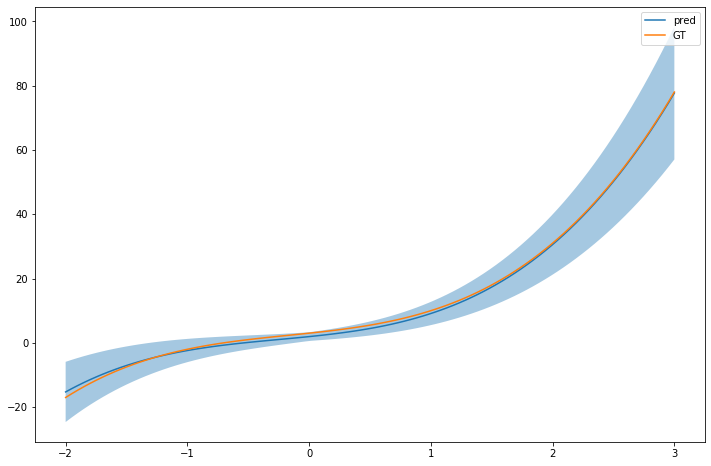

In [25]:
plt.figure(figsize=(12,8))
plt.plot(x_dense, y_dense, label='pred')
plt.plot(x_dense, y_dense_true, label='GT')
plt.fill_between(x_dense, y_min, y_max, alpha=0.4)
plt.legend();

### 95% confidence set for $\beta$

In [26]:
def bilinear(X, A):
    """
    calculates x^T A x for each x (rows of X)
    """
    return np.sum(X.dot(A) * X, axis=1)

In [27]:
from scipy.stats import chi2

In [28]:
chi2.ppf(0.95, p+1)

9.487729036781154

In [29]:
S = XTXinv * sigma_hat**2

In [30]:
beta_sign = np.random.multivariate_normal(beta_hat, S, size=1000)

In [31]:
d2 = bilinear(beta_sign - beta_hat, np.linalg.inv(S))

In [32]:
(d2 < chi2.ppf(0.95, p+1)).mean()

0.953

In [33]:
relevant_beta = beta_sign[d2 < chi2.ppf(0.95, p+1)]

In [34]:
relevant_beta.shape

(953, 4)

In [35]:
x_ = X_dense.dot(relevant_beta.T)

In [36]:
x_.shape

(100, 953)

In [37]:
y_min = x_.min(axis=1)

In [38]:
y_max = x_.max(axis=1)

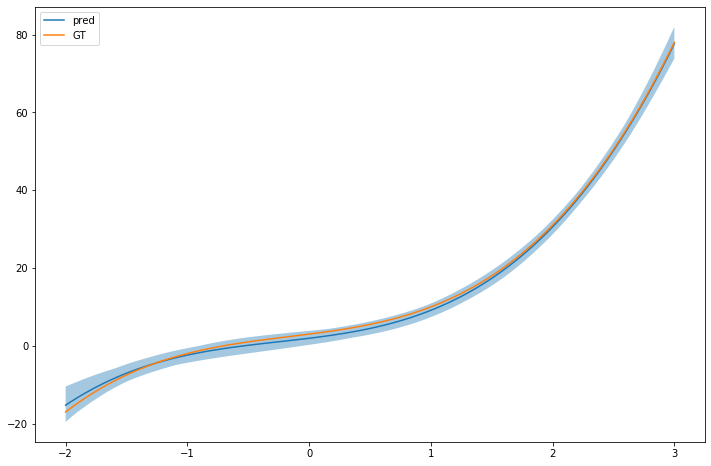

In [39]:
plt.figure(figsize=(12,8))
plt.plot(x_dense, y_dense, label='pred')
plt.plot(x_dense, y_dense_true, label='GT')
plt.fill_between(x_dense, y_min, y_max, alpha=0.4)
plt.legend();